In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [16]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi
simulator = Aer.get_backend('qasm_simulator')
noise_model = create_noise_model(cz_fidelity=1)

n = 20
m = int(n/2)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
shots_per_point = 1
def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += 1
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history



In [17]:
gammas = [1]
betas = [1]
p=1
# global circ_ex
# if circ_ex is None:
circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
# else:
#     new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
#     tm = new_circ_ex.to_dense_tn()
#     circ_ex.update_params_from(tm)
ZZ = qu.pauli('Z') & qu.pauli('Z')
ens = [
    circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
    for edge, weight in terms.items()
]

In [18]:
import networkx as nx
obj, hist = objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in np.linspace(0, bound, num=samples):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

0.0
0.16534698176788384
0.3306939635357677
0.4960409453036515
0.6613879270715354
0.8267349088394192
0.992081890607303
1.1574288723751869
1.3227758541430708
1.4881228359109546
1.6534698176788385
1.8188167994467224
1.984163781214606
2.14951076298249
2.3148577447503738
2.4802047265182576
2.6455517082861415
2.8108986900540254
2.9762456718219092
3.141592653589793


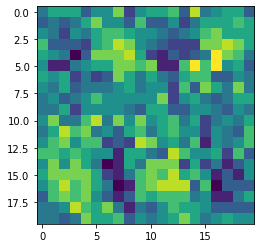

In [19]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))

In [20]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [21]:
from tqdm import tqdm
MAX_ITERATION = 100
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [22]:
history, result = test_solver(oes)


  1%|          | 1/100 [00:00<00:54,  1.81it/s]

(array([-0.42724236,  0.41121507]), 9.0, 9.0, 0.39269908169872414)


  2%|▏         | 2/100 [00:01<00:54,  1.78it/s]

(array([-0.26343952,  0.39085428]), 8.0, 8.0, 0.39269908169872414)


  3%|▎         | 3/100 [00:01<00:54,  1.79it/s]

(array([ 0.59713265, -0.21426453]), 6.0, 6.0, 0.39269908169872414)


  4%|▍         | 4/100 [00:02<00:53,  1.80it/s]

(array([ 0.39326146, -0.46678483]), 9.0, 9.0, 0.39269908169872414)


  5%|▌         | 5/100 [00:02<00:52,  1.80it/s]

(array([ 0.01252245, -0.74248732]), 8.0, 8.0, 0.39269908169872414)


  6%|▌         | 6/100 [00:03<00:52,  1.80it/s]

(array([ 0.47207228, -0.77543345]), 10.0, 10.0, 0.39269908169872414)


  7%|▋         | 7/100 [00:03<00:52,  1.78it/s]

(array([-1.22390498, -0.80001508]), 10.0, 10.0, 0.39269908169872414)


  8%|▊         | 8/100 [00:04<00:52,  1.76it/s]

(array([ 0.03728933, -0.47123449]), 8.0, 8.0, 0.39269908169872414)


  9%|▉         | 9/100 [00:05<00:51,  1.76it/s]

(array([ 0.36730142, -0.78829647]), 10.0, 10.0, 0.39269908169872414)


 10%|█         | 10/100 [00:05<00:50,  1.78it/s]

(array([-0.48771219,  0.50123169]), 9.0, 9.0, 0.39269908169872414)


 11%|█         | 11/100 [00:06<00:49,  1.78it/s]

(array([-0.22684361,  0.70387223]), 9.0, 9.0, 0.39269908169872414)


 12%|█▏        | 12/100 [00:06<00:49,  1.77it/s]

(array([ 0.42933054, -0.15224871]), 8.0, 8.0, 0.39269908169872414)


 13%|█▎        | 13/100 [00:07<00:51,  1.69it/s]

(array([-0.09216148,  0.13904973]), 8.0, 8.0, 0.39269908169872414)


 14%|█▍        | 14/100 [00:07<00:50,  1.69it/s]

(array([ 0.35086278, -0.41319533]), 9.0, 9.0, 0.39269908169872414)


 15%|█▌        | 15/100 [00:08<00:49,  1.71it/s]

(array([-0.43951686,  0.4994045 ]), 7.0, 7.0, 0.39269908169872414)


 16%|█▌        | 16/100 [00:09<00:49,  1.71it/s]

(array([-0.05787596,  0.21432072]), 6.0, 6.0, 0.39269908169872414)


 17%|█▋        | 17/100 [00:09<00:47,  1.74it/s]

(array([-0.53488186,  0.09717313]), 9.0, 9.0, 0.39269908169872414)


 18%|█▊        | 18/100 [00:10<00:46,  1.75it/s]

(array([ 0.74321285, -0.00272778]), 9.0, 9.0, 0.39269908169872414)


 19%|█▉        | 19/100 [00:10<00:46,  1.76it/s]

(array([ 0.31308818, -0.56501631]), 10.0, 10.0, 0.39269908169872414)


 20%|██        | 20/100 [00:11<00:45,  1.77it/s]

(array([-0.33843291,  0.34338723]), 8.0, 8.0, 0.39269908169872414)


 21%|██        | 21/100 [00:11<00:45,  1.73it/s]

(array([ 0.52555642, -1.03292733]), 10.0, 10.0, 0.39269908169872414)


 22%|██▏       | 22/100 [00:12<00:44,  1.75it/s]

(array([-0.34468321,  0.30203442]), 7.0, 7.0, 0.39269908169872414)


 23%|██▎       | 23/100 [00:13<00:43,  1.77it/s]

(array([-0.37798469,  0.5895502 ]), 8.0, 8.0, 0.39269908169872414)


 24%|██▍       | 24/100 [00:13<00:43,  1.75it/s]

(array([-0.03505036, -0.2477305 ]), 6.0, 6.0, 0.39269908169872414)


 25%|██▌       | 25/100 [00:14<00:42,  1.77it/s]

(array([ 0.19025117, -0.18402068]), 9.0, 9.0, 0.39269908169872414)


 26%|██▌       | 26/100 [00:14<00:42,  1.76it/s]

(array([ 0.49977568, -0.66179089]), 9.0, 9.0, 0.39269908169872414)


 27%|██▋       | 27/100 [00:15<00:41,  1.76it/s]

(array([ 0.15947942, -0.29407772]), 8.0, 8.0, 0.39269908169872414)


 28%|██▊       | 28/100 [00:15<00:40,  1.78it/s]

(array([ 0.4538524 , -0.19869831]), 9.0, 9.0, 0.39269908169872414)


 29%|██▉       | 29/100 [00:16<00:39,  1.79it/s]

(array([-0.32162032,  0.31569166]), 6.0, 6.0, 0.39269908169872414)


 30%|███       | 30/100 [00:17<00:40,  1.74it/s]

(array([ 0.23286707, -0.4848565 ]), 8.0, 8.0, 0.39269908169872414)


 31%|███       | 31/100 [00:17<00:39,  1.75it/s]

(array([ 0.43495951, -0.31689161]), 9.0, 9.0, 0.39269908169872414)


 32%|███▏      | 32/100 [00:18<00:38,  1.75it/s]

(array([-0.21836508,  0.43194579]), 8.0, 8.0, 0.39269908169872414)


 33%|███▎      | 33/100 [00:18<00:38,  1.76it/s]

(array([ 0.84109108, -0.23718322]), 8.0, 8.0, 0.39269908169872414)


 34%|███▍      | 34/100 [00:19<00:37,  1.76it/s]

(array([-0.36896828,  0.68354773]), 10.0, 10.0, 0.39269908169872414)


 35%|███▌      | 35/100 [00:19<00:36,  1.77it/s]

(array([0.49609281, 0.02429787]), 7.0, 7.0, 0.39269908169872414)


 36%|███▌      | 36/100 [00:20<00:35,  1.78it/s]

(array([-0.07631298, -0.50003387]), 8.0, 8.0, 0.39269908169872414)


 37%|███▋      | 37/100 [00:21<00:35,  1.77it/s]

(array([ 0.263487  , -0.15553283]), 6.0, 6.0, 0.39269908169872414)


 38%|███▊      | 38/100 [00:21<00:34,  1.78it/s]

(array([ 0.18641838, -0.12452825]), 9.0, 9.0, 0.39269908169872414)


 39%|███▉      | 39/100 [00:22<00:34,  1.77it/s]

(array([-0.00071568, -0.34359818]), 8.0, 8.0, 0.39269908169872414)


 40%|████      | 40/100 [00:22<00:33,  1.80it/s]

(array([ 0.01040203, -0.37755434]), 7.0, 7.0, 0.39269908169872414)


 41%|████      | 41/100 [00:23<00:32,  1.80it/s]

(array([ 0.10679034, -0.67245615]), 9.0, 9.0, 0.39269908169872414)


 42%|████▏     | 42/100 [00:23<00:32,  1.78it/s]

(array([-0.4042497 ,  0.50696287]), 8.0, 8.0, 0.39269908169872414)


 43%|████▎     | 43/100 [00:24<00:31,  1.79it/s]

(array([0.57076031, 0.00390496]), 8.0, 8.0, 0.39269908169872414)


 44%|████▍     | 44/100 [00:24<00:31,  1.79it/s]

(array([-0.02541558, -0.18796396]), 7.0, 7.0, 0.39269908169872414)


 45%|████▌     | 45/100 [00:25<00:30,  1.81it/s]

(array([ 0.26565589, -0.18311263]), 9.0, 9.0, 0.39269908169872414)


 46%|████▌     | 46/100 [00:26<00:29,  1.81it/s]

(array([-0.21739025,  0.70553669]), 8.0, 8.0, 0.39269908169872414)


 47%|████▋     | 47/100 [00:26<00:29,  1.83it/s]

(array([-0.49217066,  0.05488429]), 8.0, 8.0, 0.39269908169872414)


 48%|████▊     | 48/100 [00:27<00:28,  1.82it/s]

(array([ 0.27481183, -0.16010452]), 7.0, 7.0, 0.39269908169872414)


 49%|████▉     | 49/100 [00:27<00:28,  1.79it/s]

(array([0.89119265, 0.22944489]), 7.0, 7.0, 0.39269908169872414)


 50%|█████     | 50/100 [00:28<00:27,  1.80it/s]

(array([ 0.36091439, -0.62819721]), 10.0, 10.0, 0.39269908169872414)


 51%|█████     | 51/100 [00:28<00:27,  1.81it/s]

(array([ 0.24142241, -0.29923847]), 8.0, 8.0, 0.39269908169872414)


 52%|█████▏    | 52/100 [00:29<00:26,  1.80it/s]

(array([-0.21285719,  0.60177892]), 9.0, 9.0, 0.39269908169872414)


 53%|█████▎    | 53/100 [00:29<00:26,  1.78it/s]

(array([ 0.37397398, -0.3138985 ]), 9.0, 9.0, 0.39269908169872414)


 54%|█████▍    | 54/100 [00:30<00:25,  1.79it/s]

(array([-0.18822105,  0.29720948]), 10.0, 10.0, 0.39269908169872414)


 55%|█████▌    | 55/100 [00:31<00:25,  1.78it/s]

(array([ 0.1956509 , -0.52417114]), 7.0, 7.0, 0.39269908169872414)


 56%|█████▌    | 56/100 [00:31<00:24,  1.80it/s]

(array([ 0.54898534, -0.19856893]), 9.0, 9.0, 0.39269908169872414)


 57%|█████▋    | 57/100 [00:32<00:24,  1.79it/s]

(array([-0.01120725, -0.13837846]), 8.0, 8.0, 0.39269908169872414)


 58%|█████▊    | 58/100 [00:32<00:23,  1.77it/s]

(array([ 0.49740836, -0.17373012]), 9.0, 9.0, 0.39269908169872414)


 59%|█████▉    | 59/100 [00:33<00:23,  1.77it/s]

(array([-0.11547782,  0.23178562]), 9.0, 9.0, 0.39269908169872414)


 60%|██████    | 60/100 [00:33<00:22,  1.77it/s]

(array([ 0.0922951, -0.8451955]), 7.0, 7.0, 0.39269908169872414)


 61%|██████    | 61/100 [00:34<00:22,  1.75it/s]

(array([-0.31645866,  0.4087914 ]), 9.0, 9.0, 0.39269908169872414)


 62%|██████▏   | 62/100 [00:35<00:21,  1.75it/s]

(array([-0.29409389, -0.02197602]), 7.0, 7.0, 0.39269908169872414)


 63%|██████▎   | 63/100 [00:35<00:21,  1.74it/s]

(array([-0.10595474,  0.08279171]), 8.0, 8.0, 0.39269908169872414)


 64%|██████▍   | 64/100 [00:36<00:20,  1.74it/s]

(array([-0.45056512,  0.54493539]), 9.0, 9.0, 0.39269908169872414)


 65%|██████▌   | 65/100 [00:36<00:19,  1.76it/s]

(array([-0.62914332,  0.24032155]), 7.0, 7.0, 0.39269908169872414)


 66%|██████▌   | 66/100 [00:37<00:19,  1.75it/s]

(array([-0.18873485,  0.78043458]), 9.0, 9.0, 0.39269908169872414)


 67%|██████▋   | 67/100 [00:37<00:19,  1.73it/s]

(array([-0.27593451,  0.48027541]), 9.0, 9.0, 0.39269908169872414)


 68%|██████▊   | 68/100 [00:38<00:18,  1.75it/s]

(array([ 0.51617525, -0.78522733]), 9.0, 9.0, 0.39269908169872414)


 69%|██████▉   | 69/100 [00:39<00:17,  1.75it/s]

(array([ 0.20307427, -0.44705247]), 10.0, 10.0, 0.39269908169872414)


 70%|███████   | 70/100 [00:39<00:16,  1.77it/s]

(array([-0.21539241,  0.43770161]), 8.0, 8.0, 0.39269908169872414)


 71%|███████   | 71/100 [00:40<00:16,  1.76it/s]

(array([-0.38737977,  0.07531471]), 9.0, 9.0, 0.39269908169872414)


 72%|███████▏  | 72/100 [00:40<00:16,  1.74it/s]

(array([ 0.53661797, -0.45695548]), 10.0, 10.0, 0.39269908169872414)


 73%|███████▎  | 73/100 [00:41<00:15,  1.75it/s]

(array([ 0.33205238, -0.40236694]), 7.0, 7.0, 0.39269908169872414)


 74%|███████▍  | 74/100 [00:41<00:15,  1.65it/s]

(array([-0.49409408,  0.49276618]), 10.0, 10.0, 0.39269908169872414)


 75%|███████▌  | 75/100 [00:42<00:14,  1.69it/s]

(array([ 0.4756869 , -0.80626235]), 9.0, 9.0, 0.39269908169872414)


 76%|███████▌  | 76/100 [00:43<00:14,  1.71it/s]

(array([-0.18003611,  0.88585122]), 7.0, 7.0, 0.39269908169872414)


 77%|███████▋  | 77/100 [00:43<00:13,  1.74it/s]

(array([-0.27027787,  0.45847017]), 9.0, 9.0, 0.39269908169872414)


 78%|███████▊  | 78/100 [00:44<00:12,  1.75it/s]

(array([-0.60867812,  0.59791191]), 8.0, 8.0, 0.39269908169872414)


 79%|███████▉  | 79/100 [00:44<00:12,  1.75it/s]

(array([-0.29843617,  0.45380761]), 10.0, 10.0, 0.39269908169872414)


 80%|████████  | 80/100 [00:45<00:11,  1.74it/s]

(array([-0.62801293,  0.37658544]), 8.0, 8.0, 0.39269908169872414)


 81%|████████  | 81/100 [00:45<00:10,  1.74it/s]

(array([ 0.14141525, -0.30089752]), 10.0, 10.0, 0.39269908169872414)


 82%|████████▏ | 82/100 [00:46<00:10,  1.75it/s]

(array([ 0.16176794, -0.38321682]), 7.0, 7.0, 0.39269908169872414)


 83%|████████▎ | 83/100 [00:47<00:09,  1.76it/s]

(array([ 0.42396493, -0.11016453]), 9.0, 9.0, 0.39269908169872414)


 84%|████████▍ | 84/100 [00:47<00:08,  1.78it/s]

(array([-0.41226788,  0.64932532]), 10.0, 10.0, 0.39269908169872414)


 85%|████████▌ | 85/100 [00:48<00:08,  1.68it/s]

(array([ 0.30663999, -0.48768488]), 9.0, 9.0, 0.39269908169872414)


 86%|████████▌ | 86/100 [00:48<00:08,  1.70it/s]

(array([-0.27976543,  0.59491231]), 10.0, 10.0, 0.39269908169872414)


 87%|████████▋ | 87/100 [00:49<00:07,  1.64it/s]

(array([ 0.20988575, -0.00343669]), 7.0, 7.0, 0.39269908169872414)


 88%|████████▊ | 88/100 [00:50<00:07,  1.67it/s]

(array([ 0.38255296, -0.57141858]), 10.0, 10.0, 0.39269908169872414)


 89%|████████▉ | 89/100 [00:50<00:06,  1.65it/s]

(array([-0.47712584,  0.31973265]), 8.0, 8.0, 0.39269908169872414)


 90%|█████████ | 90/100 [00:51<00:06,  1.61it/s]

(array([ 0.14176183, -0.15794494]), 8.0, 8.0, 0.39269908169872414)


 91%|█████████ | 91/100 [00:52<00:05,  1.52it/s]

(array([ 0.00440872, -0.1250849 ]), 7.0, 7.0, 0.39269908169872414)


 92%|█████████▏| 92/100 [00:52<00:05,  1.48it/s]

(array([-0.56251825,  0.16039363]), 7.0, 7.0, 0.39269908169872414)


 93%|█████████▎| 93/100 [00:53<00:04,  1.50it/s]

(array([-0.27942328,  0.33219111]), 9.0, 9.0, 0.39269908169872414)


 94%|█████████▍| 94/100 [00:54<00:03,  1.55it/s]

(array([-0.51396311,  0.42003023]), 8.0, 8.0, 0.39269908169872414)


 95%|█████████▌| 95/100 [00:54<00:03,  1.59it/s]

(array([ 0.37395432, -0.33966582]), 8.0, 8.0, 0.39269908169872414)


 96%|█████████▌| 96/100 [00:55<00:02,  1.63it/s]

(array([ 0.62359034, -0.38164836]), 6.0, 6.0, 0.39269908169872414)


 97%|█████████▋| 97/100 [00:55<00:01,  1.66it/s]

(array([ 0.25705668, -0.22537425]), 9.0, 9.0, 0.39269908169872414)


 98%|█████████▊| 98/100 [00:56<00:01,  1.62it/s]

(array([ 0.17336834, -0.2129572 ]), 8.0, 8.0, 0.39269908169872414)


 99%|█████████▉| 99/100 [00:57<00:00,  1.62it/s]

(array([ 0.18558688, -0.26331138]), 7.0, 7.0, 0.39269908169872414)


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]

(array([ 0.06193571, -0.67602294]), 6.0, 6.0, 0.39269908169872414)
fitness at iteration 100 6.0
local optimum discovered by solver:
 [ 0.06193571 -0.67602294]
fitness score at this local optimum: 6.0


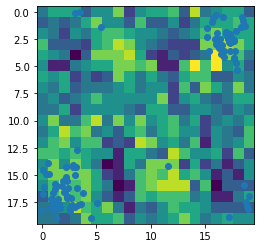

In [23]:
plt.imshow(all_data)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [el[1]%(bound)*(samples-1)/(bound) for el in xys]
plt.scatter(x, y)

# Annealing

In [24]:
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=10,
    maxfun=one_hour*reprate,
    seed=1)
result.fun = -result.fun
(result.x, result.fun)        

(array([1.99479783, 2.54754859]), 9.0)

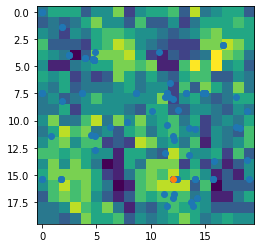

In [25]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [el[1]%(bound)*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2)
plt.scatter([result.x[0]%(bound)*(samples-1)/(bound)], [result.x[1]%(bound)*(samples-1)/(bound)])
plt.imshow(all_data)